# ADA EndSem P2

- Sampad Kumar Kar
- MCS202215

# 0. Imports

In [53]:
import os, sys
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as rmse

# for statistical tests
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 0.1 Some helper functions

In [3]:
# helper function to find the column with highest VIF and drop it from the dataframe, if it is greater than threshold
def drop_correlated_columns(df, vif_threshold):
    # select the columns which do not have the datatype as object
    df = df.select_dtypes(exclude=['object'])

    # variable set to True if we need to continue dropping columns
    flag = True

    # keep track of dropped columns
    dropped_columns = []

    while flag:
        # calculate VIF for each feature
        vif = pd.DataFrame()
        vif["features"] = df.columns
        vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

        # select the column with highest VIF
        max_col = vif.sort_values(by=['VIF'], ascending=False)['features'].iloc[0]

        # check if the VIF is greather than threshold
        if vif[vif['features'] == max_col]['VIF'].iloc[0] > vif_threshold:
            # drop the column
            df = df.drop(max_col, axis=1)
            dropped_columns.append(max_col)
        else:
            # if no column has VIF greater than threshold, exit the loop
            flag = False
        
    # print the dropped columns
    print('Dropped columns: ', dropped_columns)
    
    return vif

# 1. Data Loading

In [4]:
data_dir_path = os.path.join('data')

# read training data
df = pd.read_csv(os.path.join(data_dir_path, 'ParticipantsDatasetTraining.csv'))

df.head()

,NAME,AQI,AQI_POLLUTANT,CATEGORY,HUMIDITY,LIGHT,NO_MAX,NO_MIN,NO2_MAX,NO2_MIN,...,CO2_MIN,SOUND,TEMPRATURE_MAX,TEMPRATURE_MIN,UV_MAX,UV_MIN,AIR_PRESSURE,LASTUPDATEDATETIME,Lattitude,Longitude
0,ABC Farm House Junction_4,117.71,CO,MODERATE,17.463,3366.12,0,0,60.0,40.0,...,308.0,85.321,42.0,24.0,2.1,0.1,0.931,5/13/2019 12:15,18.538857,73.903019
1,BRTS Visharant wadi_38,121.84,NO2,MODERATE,21.642,1349.702,0,0,70.0,66.0,...,0.0,83.599,38.0,25.0,0.3,0.1,0.931,5/13/2019 12:15,18.561238,73.878972
2,ChurchKhadakiRailwayStation_36,108.11,NO2,MODERATE,21.131,2128.711,0,0,62.0,56.0,...,421.0,72.519,40.0,24.0,0.9,0.1,0.930,5/13/2019 12:15,18.562059,73.808384
3,Kothrud PMPML BusDepot_48,134.01,NO2,MODERATE,17.926,840.325,0,0,77.0,75.0,...,251.0,75.843,42.0,24.0,2.8,0.1,0.927,5/13/2019 12:15,18.506206,73.792772
4,Market Yard Junction_2,142.61,NO2,MODERATE,19.240,2549.996,0,0,86.0,82.0,...,337.0,78.756,40.0,26.0,3.4,0.1,0.927,5/13/2019 12:15,18.481994,73.874147


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417637 entries, 0 to 417636
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   NAME                417637 non-null  object 
 1   AQI                 417637 non-null  float64
 2   AQI_POLLUTANT       415484 non-null  object 
 3   CATEGORY            417635 non-null  object 
 4   HUMIDITY            375670 non-null  float64
 5   LIGHT               370494 non-null  object 
 6   NO_MAX              417637 non-null  int64  
 7   NO_MIN              417637 non-null  int64  
 8   NO2_MAX             413854 non-null  float64
 9   NO2_MIN             413854 non-null  float64
 10  OZONE_MAX           413787 non-null  float64
 11  OZONE_MIN           413787 non-null  float64
 12  PM10_MAX            411494 non-null  float64
 13  PM10_MIN            411494 non-null  float64
 14  PM2_MAX             411494 non-null  float64
 15  PM2_MIN             411494 non-nul

In [6]:
# read the test data
df_test = pd.read_csv(os.path.join(data_dir_path, 'ParticipantsDatasetTest.csv'))

df_test.head()

,NAME,HUMIDITY,LIGHT,NO_MAX,NO_MIN,NO2_MAX,NO2_MIN,OZONE_MAX,OZONE_MIN,PM10_MAX,...,CO2_MIN,SOUND,TEMPRATURE_MAX,TEMPRATURE_MIN,UV_MAX,UV_MIN,AIR_PRESSURE,LASTUPDATEDATETIME,Lattitude,Longitude
0,PMPML_Bus_Depot_Deccan_15,71.806,3167.854,0,0,98.0,96.0,0.0,0.0,8.0,...,0.0,85.431,28.0,24.0,1.4,0.4,0.930,9/6/2019 8:00,18.451716,73.856170
1,Rajashri_Shahu_Bus_stand_19,76.809,1536.079,0,0,54.0,52.0,7.0,3.0,1.0,...,0.0,81.190,28.0,23.0,1.4,0.4,0.925,9/6/2019 8:00,18.482239,73.858092
2,Hadapsar_Gadital_01,73.903,3388.676,0,0,0.0,0.0,71.0,59.0,5.0,...,142.0,80.864,27.0,24.0,0.1,0.1,0.928,9/6/2019 8:00,18.501834,73.941478
3,Dr Baba Saheb Ambedkar Sethu Junction_60,83.984,2530.419,0,0,37.0,34.0,17.0,10.0,20.0,...,334.0,83.841,28.0,24.0,0.1,0.1,0.930,9/6/2019 8:00,18.551763,73.830648
4,Lullanagar_Square_14,74.412,1831.434,0,0,40.0,36.0,50.0,27.0,4.0,...,0.0,67.681,27.0,23.0,0.6,0.1,0.924,9/6/2019 8:00,18.487306,73.885650


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103205 entries, 0 to 103204
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   NAME                103205 non-null  object 
 1   HUMIDITY            98084 non-null   float64
 2   LIGHT               97133 non-null   float64
 3   NO_MAX              103205 non-null  int64  
 4   NO_MIN              103205 non-null  int64  
 5   NO2_MAX             102628 non-null  float64
 6   NO2_MIN             102628 non-null  float64
 7   OZONE_MAX           102597 non-null  float64
 8   OZONE_MIN           102597 non-null  float64
 9   PM10_MAX            99972 non-null   float64
 10  PM10_MIN            99972 non-null   float64
 11  PM2_MAX             99972 non-null   float64
 12  PM2_MIN             99972 non-null   float64
 13  SO2_MAX             102368 non-null  float64
 14  SO2_MIN             102368 non-null  float64
 15  CO_MAX              102597 non-nul

## 2. EDA

In [8]:
# show the shape of the data
print('Shape of the data:')
print(df.shape)

Shape of the data:
(417637, 31)


In [9]:
# check the unique pollutants in the 'AQI_POLLUTANT' column
print("Unique pollutants:")
print(df['AQI_POLLUTANT'].unique())

Unique pollutants:
['CO' 'NO2' nan 'OZONE' 'SO2' 'PM10' 'PM2.5']


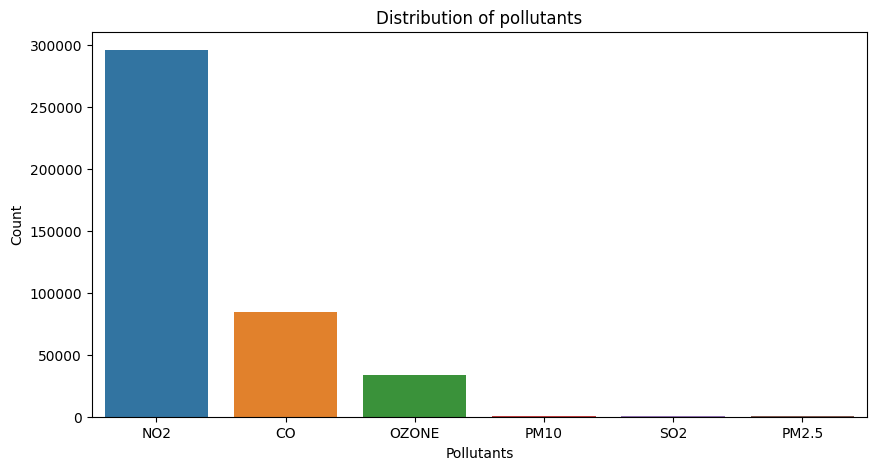

In [10]:
# plot the distribution of the unique pollutants
plt.figure(figsize=(10, 5))
sns.barplot(x=df['AQI_POLLUTANT'].value_counts().index, y=df['AQI_POLLUTANT'].value_counts())
plt.xlabel('Pollutants')
plt.ylabel('Count')
plt.title('Distribution of pollutants')
plt.show()

As evident from the above plot, `NO2` seems like the most frequent pollutant in the dataset.

In [11]:
# check the unique AQI categories from the 'CATEGORY' column
print(df['CATEGORY'].unique())

['MODERATE' 'SATISFACTORY' 'POOR' 'nullvalue' 'VERY_POOR' 'GOOD' 'SEVERE'
 nan]


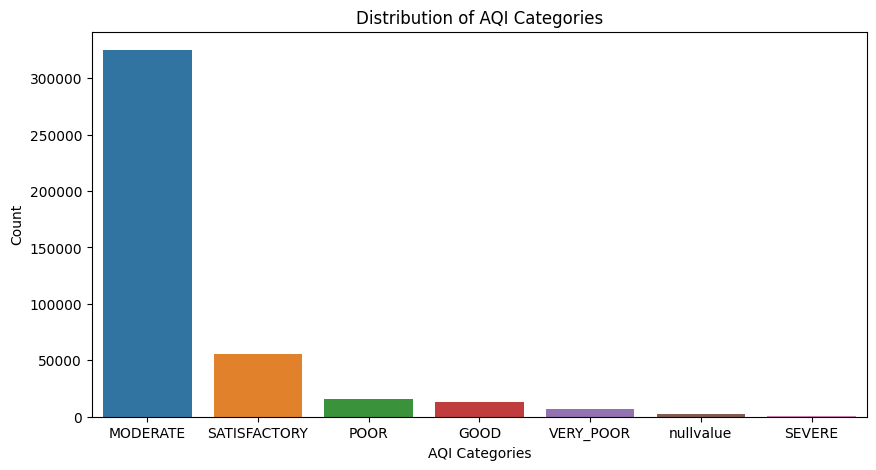

In [12]:
# plot the distribution of the unique AQI categories
plt.figure(figsize=(10, 5))
sns.barplot(x=df['CATEGORY'].value_counts().index, y=df['CATEGORY'].value_counts())
plt.xlabel('AQI Categories')
plt.ylabel('Count')
plt.title('Distribution of AQI Categories')
plt.show()

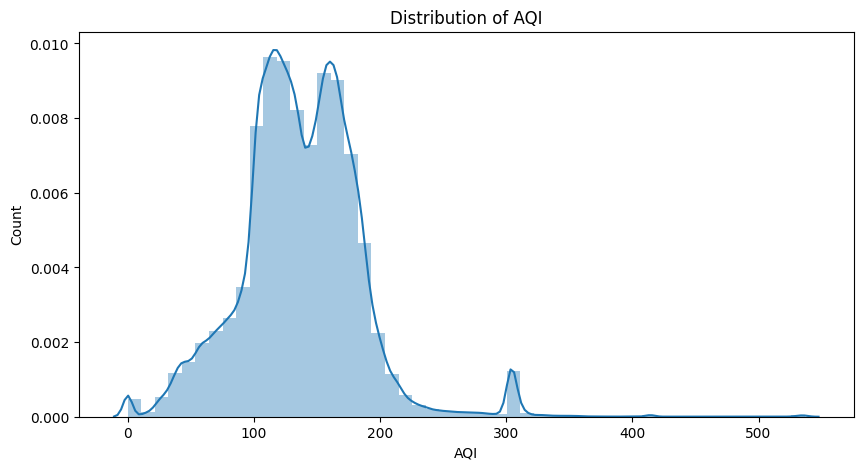

In [13]:
# plot the distribution of the target column, i.e. 'AQI'
plt.figure(figsize=(10, 5))
sns.distplot(df['AQI'])
plt.xlabel('AQI')
plt.ylabel('Count')
plt.title('Distribution of AQI')
plt.show()

# 3. Data Preprocessing

In [14]:
df.columns

Index(['NAME', 'AQI', 'AQI_POLLUTANT', 'CATEGORY', 'HUMIDITY', 'LIGHT',
       'NO_MAX', 'NO_MIN', 'NO2_MAX', 'NO2_MIN', 'OZONE_MAX', 'OZONE_MIN',
       'PM10_MAX', 'PM10_MIN', 'PM2_MAX', 'PM2_MIN', 'SO2_MAX', 'SO2_MIN',
       'CO_MAX', 'CO_MIN', 'CO2_MAX', 'CO2_MIN', 'SOUND', 'TEMPRATURE_MAX',
       'TEMPRATURE_MIN', 'UV_MAX', 'UV_MIN', 'AIR_PRESSURE',
       'LASTUPDATEDATETIME', 'Lattitude', 'Longitude'],
      dtype='object')

In [15]:
# we first drop the columns not required for training
COLUMNS_TO_DROP_TRAIN = ['NAME', 'AQI_POLLUTANT', 'CATEGORY', 'NO_MAX', 'NO_MIN', 'LASTUPDATEDATETIME', 'Lattitude', 'Longitude']
COLUMNS_TO_DROP_TEST = ['NAME', 'LASTUPDATEDATETIME', 'NO_MAX', 'NO_MIN', 'Lattitude', 'Longitude']

train_data = df.drop(COLUMNS_TO_DROP_TRAIN, axis=1)
test_data = df_test.drop(COLUMNS_TO_DROP_TEST, axis=1)

train_data.head()

,AQI,HUMIDITY,LIGHT,NO2_MAX,NO2_MIN,OZONE_MAX,OZONE_MIN,PM10_MAX,PM10_MIN,PM2_MAX,...,CO_MAX,CO_MIN,CO2_MAX,CO2_MIN,SOUND,TEMPRATURE_MAX,TEMPRATURE_MIN,UV_MAX,UV_MIN,AIR_PRESSURE
0,117.71,17.463,3366.12,60.0,40.0,13.0,0.0,22.0,16.0,18.0,...,123.0,71.0,374.0,308.0,85.321,42.0,24.0,2.1,0.1,0.931
1,121.84,21.642,1349.702,70.0,66.0,20.0,0.0,27.0,22.0,22.0,...,106.0,55.0,0.0,0.0,83.599,38.0,25.0,0.3,0.1,0.931
2,108.11,21.131,2128.711,62.0,56.0,36.0,0.0,23.0,19.0,19.0,...,106.0,69.0,441.0,421.0,72.519,40.0,24.0,0.9,0.1,0.930
3,134.01,17.926,840.325,77.0,75.0,21.0,0.0,21.0,17.0,17.0,...,119.0,61.0,315.0,251.0,75.843,42.0,24.0,2.8,0.1,0.927
4,142.61,19.240,2549.996,86.0,82.0,6.0,0.0,27.0,23.0,22.0,...,108.0,49.0,432.0,337.0,78.756,40.0,26.0,3.4,0.1,0.927


## 3.1 Handling Missing Values

In [16]:
# check for missing values
train_data.isnull().sum()

AQI                   0
HUMIDITY          41967
LIGHT             47143
NO2_MAX            3783
NO2_MIN            3783
OZONE_MAX          3850
OZONE_MIN          3850
PM10_MAX           6143
PM10_MIN           6143
PM2_MAX            6143
PM2_MIN            6143
SO2_MAX           12109
SO2_MIN           12109
CO_MAX             2950
CO_MIN             2950
CO2_MAX            5718
CO2_MIN            5718
SOUND             41962
TEMPRATURE_MAX    34383
TEMPRATURE_MIN    34383
UV_MAX            24721
UV_MIN            24721
AIR_PRESSURE      41958
dtype: int64

In [17]:
# 'LIGHT' column shows 'object' datatype, make it numeric
train_data['LIGHT'] = pd.to_numeric(train_data['LIGHT'], errors='coerce')

We use a simple imputer to fill in the missing values, with the median of the columns, within our preprocessing pipeline.

In [18]:
# create a dictionary to store the median values of each column in 'train_data'

median_dict = {}

for col in train_data.columns:
    if col != 'AQI':
        median_dict[col] = train_data[col].median()

print(median_dict)

{'HUMIDITY': 70.102, 'LIGHT': 213.804, 'NO2_MAX': 77.0, 'NO2_MIN': 67.0, 'OZONE_MAX': 13.0, 'OZONE_MIN': 0.0, 'PM10_MAX': 15.0, 'PM10_MIN': 11.0, 'PM2_MAX': 13.0, 'PM2_MIN': 9.0, 'SO2_MAX': 3.0, 'SO2_MIN': 2.0, 'CO_MAX': 103.0, 'CO_MIN': 39.0, 'CO2_MAX': 278.0, 'CO2_MIN': 112.0, 'SOUND': 74.818, 'TEMPRATURE_MAX': 33.0, 'TEMPRATURE_MIN': 24.0, 'UV_MAX': 0.4, 'UV_MIN': 0.1, 'AIR_PRESSURE': 0.93}


In [19]:
# we use simple imputer to fill the missing values in both 'train_data' dataframe and 'df_test' dataframe

for col in median_dict.keys():
    train_data[col].fillna(median_dict[col], inplace=True)
    test_data[col].fillna(median_dict[col], inplace=True)

In [20]:
# check for missing values in 'train_data'
train_data.isnull().sum()

AQI               0
HUMIDITY          0
LIGHT             0
NO2_MAX           0
NO2_MIN           0
OZONE_MAX         0
OZONE_MIN         0
PM10_MAX          0
PM10_MIN          0
PM2_MAX           0
PM2_MIN           0
SO2_MAX           0
SO2_MIN           0
CO_MAX            0
CO_MIN            0
CO2_MAX           0
CO2_MIN           0
SOUND             0
TEMPRATURE_MAX    0
TEMPRATURE_MIN    0
UV_MAX            0
UV_MIN            0
AIR_PRESSURE      0
dtype: int64

In [21]:
# check for missing values in 'df_test'
test_data.isnull().sum()

HUMIDITY          0
LIGHT             0
NO2_MAX           0
NO2_MIN           0
OZONE_MAX         0
OZONE_MIN         0
PM10_MAX          0
PM10_MIN          0
PM2_MAX           0
PM2_MIN           0
SO2_MAX           0
SO2_MIN           0
CO_MAX            0
CO_MIN            0
CO2_MAX           0
CO2_MIN           0
SOUND             0
TEMPRATURE_MAX    0
TEMPRATURE_MIN    0
UV_MAX            0
UV_MIN            0
AIR_PRESSURE      0
dtype: int64

As we can see, we have managed to remove the missing values from both train and test datasets.

## 3.2 Feature Engineering

We create a preprocessing pipeline which does the follwing:
- for columns in `['NO', 'NO2', 'OZONE', 'PM10', 'PM2', 'SO2', 'CO', 'CO2', 'TEMPRATURE', 'UV']`, we add an engineered column which stores the average of min and max values of the column and drops the min and max columns.

In [22]:
# we create a helper function to do the preprocessing of the data

def preprocess_pipeline(df, cols):
    data = df.copy()
    for col in cols:
        df[str(col) + '_AVG'] = (df[str(col + '_MIN')] + df[str(col + '_MAX')])/2
        df.drop([str(col + '_MIN'), str(col + '_MAX')], axis=1, inplace=True)
    return df

In [23]:
COLUMNS_TO_MODIFY = ['NO2', 'OZONE', 'PM10', 'PM2', 'SO2', 'CO', 'CO2', 'TEMPRATURE', 'UV']

# we modify both the train and test dataframes
train_data_new = preprocess_pipeline(train_data, COLUMNS_TO_MODIFY)
test_data_new = preprocess_pipeline(test_data, COLUMNS_TO_MODIFY)

In [24]:
train_data_new.head()

,AQI,HUMIDITY,LIGHT,SOUND,AIR_PRESSURE,NO2_AVG,OZONE_AVG,PM10_AVG,PM2_AVG,SO2_AVG,CO_AVG,CO2_AVG,TEMPRATURE_AVG,UV_AVG
0,117.71,17.463,3366.120,85.321,0.931,50.0,6.5,19.0,16.0,2.0,97.0,341.0,33.0,1.10
1,121.84,21.642,1349.702,83.599,0.931,68.0,10.0,24.5,20.5,3.0,80.5,0.0,31.5,0.20
2,108.11,21.131,2128.711,72.519,0.930,59.0,18.0,21.0,18.0,3.0,87.5,431.0,32.0,0.50
3,134.01,17.926,840.325,75.843,0.927,76.0,10.5,19.0,15.5,4.5,90.0,283.0,33.0,1.45
4,142.61,19.240,2549.996,78.756,0.927,84.0,3.0,25.0,21.0,3.0,78.5,384.5,33.0,1.75


In [25]:
test_data_new.head()

,HUMIDITY,LIGHT,SOUND,AIR_PRESSURE,NO2_AVG,OZONE_AVG,PM10_AVG,PM2_AVG,SO2_AVG,CO_AVG,CO2_AVG,TEMPRATURE_AVG,UV_AVG
0,71.806,3167.854,85.431,0.930,97.0,0.0,7.5,4.5,8.0,66.5,0.0,26.0,0.90
1,76.809,1536.079,81.190,0.925,53.0,5.0,1.0,0.5,0.0,15.5,0.0,25.5,0.90
2,73.903,3388.676,80.864,0.928,0.0,65.0,4.5,3.0,3.0,77.5,173.0,25.5,0.10
3,83.984,2530.419,83.841,0.930,35.5,13.5,17.5,7.5,6.0,46.5,353.0,26.0,0.10
4,74.412,1831.434,67.681,0.924,38.0,38.5,3.5,2.5,0.0,25.5,0.0,25.0,0.35


## 3.3 Multicollinearity Check

In [26]:
# we focus only on the feature columns
train_features = train_data_new.drop(['AQI'], axis=1)

### 3.3.1 Correlation Matrix

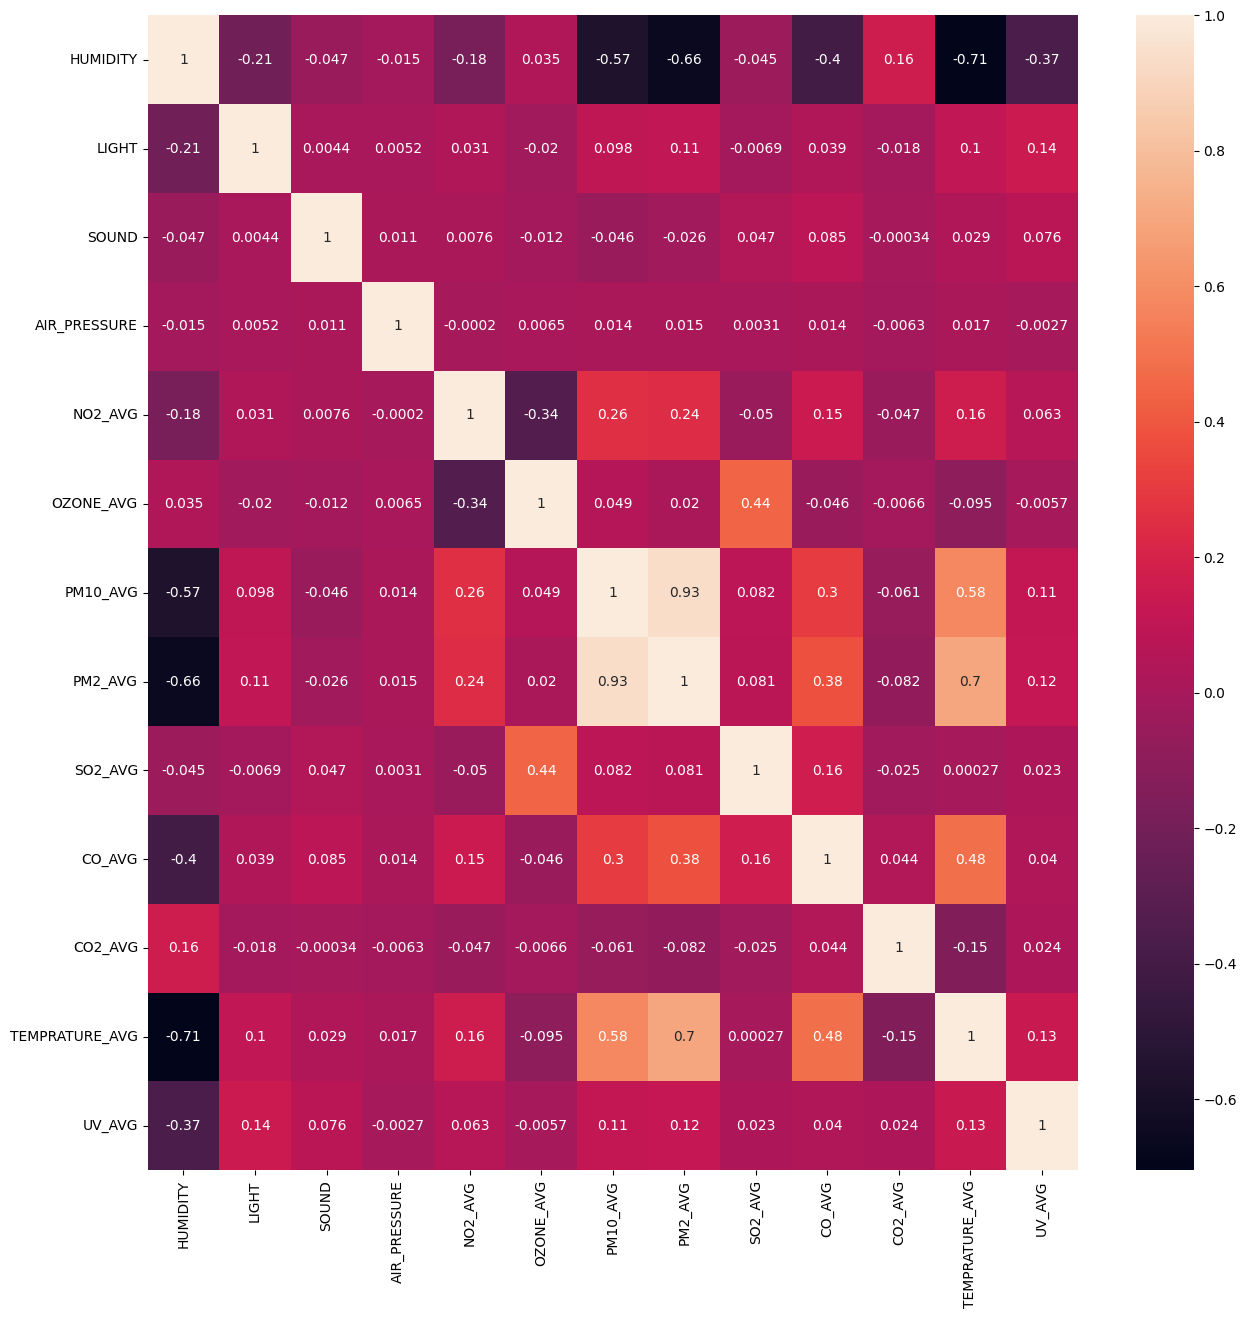

In [27]:
corr_matrix = train_features.corr()

# plot the heatmap of the correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

### 3.3.2 Variance Inflation Factor

We also check for multicollinearity using the VIF values. Columns with VIF values greater than `10` are considered to be highly correlated.

Here is how we calculate the VIF values:

$$VIF_i = \frac{1}{1 - R_i^2}$$

where $R_i^2$ is the $R^2$ value of the regression of the $i^{th}$ feature on all the other features.

We drop the variables one after another, in decreasing order of their VIF values, until all the VIF values are less than `10` for the remaining columns. For this we use the helper function `drop_correlated_columns`.

In [28]:
%%time

threshold = 10

vif = drop_correlated_columns(train_features, threshold)
vif

Dropped columns:  ['AIR_PRESSURE', 'TEMPRATURE_AVG', 'SOUND', 'PM2_AVG']
CPU times: user 1min 7s, sys: 13.8 s, total: 1min 21s
Wall time: 11.4 s


,features,VIF
0,HUMIDITY,5.608375
1,LIGHT,1.199284
2,NO2_AVG,6.314320
3,OZONE_AVG,1.949500
4,PM10_AVG,3.104234
5,SO2_AVG,1.814127
6,CO_AVG,5.446068
7,CO2_AVG,2.250532
8,UV_AVG,1.627177


So, due to multicollinearity, we drop the following columns:
- `AIR_PRESSURE`
- `TEMPRATURE_AVG`
- `SOUND`
- `PM2_AVG`

In [30]:
# drop these columns in both train and test dataframes
MULTICOLLINEAR_COLUMNS = ['AIR_PRESSURE', 'TEMPRATURE_AVG', 'SOUND', 'PM2_AVG']

train_data_new.drop(MULTICOLLINEAR_COLUMNS, axis=1, inplace=True)
test_data_new.drop(MULTICOLLINEAR_COLUMNS, axis=1, inplace=True)

train_data_new.head()

,AQI,HUMIDITY,LIGHT,NO2_AVG,OZONE_AVG,PM10_AVG,SO2_AVG,CO_AVG,CO2_AVG,UV_AVG
0,117.71,17.463,3366.120,50.0,6.5,19.0,2.0,97.0,341.0,1.10
1,121.84,21.642,1349.702,68.0,10.0,24.5,3.0,80.5,0.0,0.20
2,108.11,21.131,2128.711,59.0,18.0,21.0,3.0,87.5,431.0,0.50
3,134.01,17.926,840.325,76.0,10.5,19.0,4.5,90.0,283.0,1.45
4,142.61,19.240,2549.996,84.0,3.0,25.0,3.0,78.5,384.5,1.75


# 4. Model Fitting

In [31]:
# first extract the features and target from the dataframe
X_train = train_data_new.drop(['AQI'], axis=1)
y_train = train_data_new['AQI']

# print the shape of the features and target
print('Shape of features: ', X_train.shape)
print('Shape of target: ', y_train.shape)

Shape of features:  (417637, 9)
Shape of target:  (417637,)


We fit a Random Forest Regerssor with the following hyperparameters:
- `n_estimators`: 300
- `max_depth`: 10
- `min_samples_split`: 2

In [36]:
%%time

rf_reg = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=2)
rf_reg.fit(X_train, y_train)

CPU times: user 4min 44s, sys: 153 ms, total: 4min 44s
Wall time: 4min 45s


RandomForestRegressor(max_depth=10, n_estimators=300)

In [40]:
# make predictions on the test data
X_test = test_data_new.copy()
y_test_pred = rf_reg.predict(X_test)

# 5. Evaluation

In [45]:
# we first append the predictions to the test dataframe
test_data_new['AQI_pred'] = y_test_pred
test_data_new['NAME'] = df_test['NAME']

test_data_new.head()

,HUMIDITY,LIGHT,NO2_AVG,OZONE_AVG,PM10_AVG,SO2_AVG,CO_AVG,CO2_AVG,UV_AVG,AQI_pred,NAME
0,71.806,3167.854,97.0,0.0,7.5,8.0,66.5,0.0,0.90,181.237588,PMPML_Bus_Depot_Deccan_15
1,76.809,1536.079,53.0,5.0,1.0,0.0,15.5,0.0,0.90,100.056380,Rajashri_Shahu_Bus_stand_19
2,73.903,3388.676,0.0,65.0,4.5,3.0,77.5,173.0,0.10,152.630957,Hadapsar_Gadital_01
3,83.984,2530.419,35.5,13.5,17.5,6.0,46.5,353.0,0.10,74.555077,Dr Baba Saheb Ambedkar Sethu Junction_60
4,74.412,1831.434,38.0,38.5,3.5,0.0,25.5,0.0,0.35,102.086760,Lullanagar_Square_14


We evaluate on the `submission.csv` file, which contains the test data.

In [46]:
df_sub = pd.read_csv(os.path.join(data_dir_path, 'submission.csv'))
df_sub.head()

,Name,AQI1,AQI2,AQI3,AQI4,AQI5,AQI6
0,BopadiSquare_65,84.808942,66.984753,212.773085,128.965767,92.943679,159.949704
1,Karve Statue Square_5,278.170491,139.321475,208.128277,97.258325,283.685582,72.520696
2,Lullanagar_Square_14,256.754092,28.435734,100.617271,96.165439,228.241990,170.610234
3,Hadapsar_Gadital_01,96.086463,208.857270,269.804955,58.276911,150.764215,181.739433
4,PMPML_Bus_Depot_Deccan_15,178.606041,195.090272,196.631882,295.091421,11.531983,236.812520


We add a target column named `AQI_actual`, which is the mean of the following columns:
- `AQI1`
- `AQI2`
- `AQI3`
- `AQI4`
- `AQI5`
- `AQI6`

In [47]:
df_sub.columns

Index(['Name', 'AQI1', 'AQI2', 'AQI3', 'AQI4', 'AQI5', 'AQI6'], dtype='object')

In [49]:
# add the `AQI_actual`
df_sub['AQI_actual'] = df_sub[['AQI1', 'AQI2', 'AQI3', 'AQI4', 'AQI5', 'AQI6']].mean(axis=1)
df_sub.head()

,Name,AQI1,AQI2,AQI3,AQI4,AQI5,AQI6,AQI_actual
0,BopadiSquare_65,84.808942,66.984753,212.773085,128.965767,92.943679,159.949704,124.404322
1,Karve Statue Square_5,278.170491,139.321475,208.128277,97.258325,283.685582,72.520696,179.847474
2,Lullanagar_Square_14,256.754092,28.435734,100.617271,96.165439,228.241990,170.610234,146.804127
3,Hadapsar_Gadital_01,96.086463,208.857270,269.804955,58.276911,150.764215,181.739433,160.921541
4,PMPML_Bus_Depot_Deccan_15,178.606041,195.090272,196.631882,295.091421,11.531983,236.812520,185.627353


In `df_sub` dataframe, the predicted AQI values will be stored in the `AQI_pred` column. For each row, we calculate the `AQI_pred` in the following manner:
- we first select the `Name` of the station
- then we select all the rows in `test_data_new` which have the same `Name` as the selected station
- then we calculate the mean of the `AQI` column of the selected rows
- this mean is then stored in the `AQI_pred` column of the selected row in `df_sub`

In [51]:
'''
In `df_sub` dataframe, the predicted AQI values will be stored in the `AQI_pred` column. For each row, we calculate the `AQI_pred` in the following manner:
- we first select the `Name` of the station
- then we select all the rows in `test_data_new` which have the same `Name` as the selected station
- then we calculate the mean of the `AQI` column of the selected rows
- this mean is then stored in the `AQI_pred` column of the selected row in `df_sub`
'''

# add a new column `AQI_pred` to `df_sub`
df_sub['AQI_pred'] = 0

for i in range(df_sub.shape[0]):
    station_name = df_sub['Name'].iloc[i]
    df_sub['AQI_pred'].iloc[i] = test_data_new[test_data_new['NAME'] == station_name]['AQI_pred'].mean()

df_sub.head()

,Name,AQI1,AQI2,AQI3,AQI4,AQI5,AQI6,AQI_actual,AQI_pred
0,BopadiSquare_65,84.808942,66.984753,212.773085,128.965767,92.943679,159.949704,124.404322,140.014670
1,Karve Statue Square_5,278.170491,139.321475,208.128277,97.258325,283.685582,72.520696,179.847474,130.141327
2,Lullanagar_Square_14,256.754092,28.435734,100.617271,96.165439,228.241990,170.610234,146.804127,116.649948
3,Hadapsar_Gadital_01,96.086463,208.857270,269.804955,58.276911,150.764215,181.739433,160.921541,184.868126
4,PMPML_Bus_Depot_Deccan_15,178.606041,195.090272,196.631882,295.091421,11.531983,236.812520,185.627353,157.629511


## 5.1 RMSE

In [55]:
# we calculate the RMSE of AQI_pred against AQI_actual

print('RMSE: ', rmse(df_sub['AQI_actual'], df_sub['AQI_pred'], squared=False))

RMSE:  42.70733241765071


So, we end up obtaining a reasonable model with a low RMSE of `42.7`, which is indicative of a good fit.